In [ ]:
import pandas as pd
import numpy as np
import pymorphy2
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import time
from tqdm import tqdm
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import gc


## Read data

In [ ]:
path = 'test_data_exam_1.xlsx'

In [ ]:
df = pd.read_excel(path, 0)

In [ ]:
num_rows, num_feature = df.shape
print('Row number: ', num_rows)
print('Feature number: ', num_feature)

Row number:  8048
Feature number:  2


In [ ]:
print(df.isna().sum())

original_data    21
score             0
dtype: int64


In [ ]:
df = df.dropna(axis=0)
df.reset_index(inplace=True, drop=True)

In [ ]:
num_rows, num_feature = df.shape
print('Row number: ', num_rows)
print('Feature number: ', num_feature)

Row number:  8027
Feature number:  2


In [ ]:
vc = df['score'].value_counts()

In [ ]:
vc

 0    4180
-1    2746
 1     523
-2     473
 2     105
Name: score, dtype: int64

In [ ]:
 0    4180
-1    2746
 1     523
-2     473
 2     105

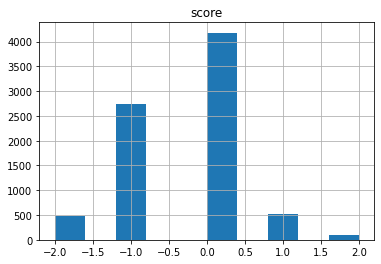

In [ ]:
df.hist('score')
plt.show()

In [ ]:
y_test = df['score'].to_numpy()
df.drop('score', inplace=True, axis=1)
data = df.to_numpy()
data = data.ravel()

In [ ]:
del df
gc.collect()

4314

In [ ]:
y_test

array([0, 0, 1, ..., 0, 0, 0])

## Clean and lemmatize

In [ ]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [ ]:
morph = pymorphy2.MorphAnalyzer()

In [ ]:
X = []
for i in tqdm(range(data.shape[0])):
    s = str(data[i])
    s = s.lower()
    s1 = re.sub(r"[,.?“/!@#$1234567890#—ツ►๑۩۞۩•*”˜˜”*°°*`)(]", '', s)
    word_list = nltk.word_tokenize(s1)
    words = [morph.parse(word)[0].normal_form for word in word_list]
    X.append(words)

100%|██████████| 18729/18729 [09:12<00:00, 33.87it/s]


In [ ]:
import pickle
with open('doc_train.pickle', 'wb') as f:
  pickle.dump(documents, f)

In [ ]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(X)]

In [ ]:
del X
gc.collect()

0

## Doc2vec

In [ ]:
model = Doc2Vec(vector_size=300, window=2, min_count=1, workers=4, dm=0)

In [ ]:
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=100)

In [ ]:
dv_test = []

In [ ]:
for i in tqdm(range(len(documents2))):
  dv_test.append(model.infer_vector(documents2[i][0]))

100%|██████████| 8027/8027 [04:04<00:00, 32.82it/s]


In [ ]:
dv_test = np.array(dv_test)

In [ ]:
dv_test.shape

(8027, 300)

In [ ]:
dv = model.docvecs.doctag_syn0

<ipython-input-24-4a3c507c18b5>:1: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  dv = model.docvecs.doctag_syn0


In [ ]:
dv.shape

(18729, 300)

In [ ]:
import pickle
with open('dv_train.pickle', 'wb') as f:
  pickle.dump(dv, f)

In [ ]:
path = 'test_data_exam_1.xlsx'
df = pd.read_excel(path, 0)
df = df.dropna(axis=0)
df.reset_index(inplace=True, drop=True)
y = df['score'].to_numpy()
df.drop('score', inplace=True, axis=1)
data = df.to_numpy()
data = data.ravel()
del df
gc.collect()

8203

In [ ]:
morph = pymorphy2.MorphAnalyzer()
X = []
for i in tqdm(range(data.shape[0])):
    s = str(data[i])
    s = s.lower()
    s1 = re.sub(r"[,.?“/!@#$1234567890#—ツ►๑۩۞۩•*”˜˜”*°°*`)(]", '', s)
    word_list = nltk.word_tokenize(s1)
    words = [morph.parse(word)[0].normal_form for word in word_list]
    X.append(words)

documents2 = [TaggedDocument(doc, [i]) for i, doc in enumerate(X)]
del X
gc.collect()

100%|██████████| 8027/8027 [03:54<00:00, 34.20it/s]


8479

In [ ]:
import pickle
with open('dv_test', 'wb') as f:
  pickle.dump(dv_test, f)

## DATA

In [ ]:
y_train.shape

(18729,)

In [ ]:
with open('dv_test', 'rb') as f:
  dv_test = pickle.load(f)

In [ ]:
dv_train = np.array(dv)

In [ ]:
dv_train.shape

(18729, 300)

In [ ]:
dv_test.shape

(8027, 300)

## Resample

In [ ]:
df1 = pd.DataFrame(data=dv_test)

In [ ]:
df1['score'] = pd.Series(data=y_test)

In [ ]:
df1['score'].value_counts()

 0    4180
-1    2746
 1     523
-2     473
 2     105
Name: score, dtype: int64

In [ ]:
from sklearn.utils import resample

In [ ]:
neg_2 = resample(df1[df1['score'] == -2], replace=True, n_samples=3000)

In [ ]:
neg_1 = resample(df1[df1['score'] == -1], replace=True, n_samples=3000)

In [ ]:
neu = resample(df1[df1['score'] == 0], replace=True, n_samples=3000)

In [ ]:
pos_1 = resample(df1[df1['score'] == 1], replace=True, n_samples=3000)

In [ ]:
pos_2 = resample(df1[df1['score'] == 2], replace=True, n_samples=3000)

In [ ]:
df2 = pd.concat([neg_2, neg_1, neu, pos_1, pos_2])

In [ ]:
del neg_1, neg_2, neu, pos_1, pos_2, df1
gc.collect()

180

In [ ]:
df2.shape

(15000, 301)

In [ ]:
df1.reset_index(inplace=True, drop=True)

In [ ]:
df1.columns = df1.columns.astype(str)

In [ ]:
df1

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,score
0,0.725479,0.241782,0.196511,-0.491044,-0.675583,-0.925679,0.793826,-0.504964,-0.309309,0.567520,...,0.428354,-0.775855,0.399552,0.330598,-0.257333,0.775793,0.074674,-0.233569,0.293203,0
1,0.604367,0.286039,-0.050120,-0.394460,-0.372753,-0.579163,0.234704,0.174969,0.010553,-0.029779,...,0.071632,-0.259794,0.451733,-0.889941,-0.069556,-0.119188,0.347308,0.416245,-0.817566,0
2,-0.324145,0.074789,-0.369120,0.476153,0.600380,-1.089299,0.509284,-0.702618,0.333241,-0.163175,...,0.616127,0.650183,-0.302751,-0.260221,0.067306,0.332898,-0.241929,-0.169211,-0.902173,1
3,0.066521,0.812741,-0.111264,-0.063492,0.465883,-0.633962,0.188607,-0.346522,-0.458842,-0.419786,...,-0.055647,0.011968,-0.002347,0.365783,0.089735,-0.623509,0.801214,-0.425029,0.119087,-1
4,0.715068,0.108263,0.042148,-0.313054,0.146950,-1.139843,-0.578832,-0.522158,-0.388335,0.157705,...,0.043824,0.215929,-0.099605,0.067155,-0.673705,-0.228468,0.287671,-0.468357,0.101548,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8022,0.942091,0.495511,0.361698,-0.070220,-0.160352,-0.839838,0.048999,-0.278410,0.087714,0.543629,...,-0.596566,0.499181,0.124303,0.439629,-0.537780,1.308473,0.314554,0.326208,0.941027,0
8023,0.544524,0.312927,0.338421,-0.861592,-0.562364,0.028820,0.098921,-0.013825,-0.538288,-0.046086,...,0.335222,-0.164031,0.083966,-0.951246,1.042996,-0.155475,0.834190,-0.847340,-0.513757,0
8024,0.840044,-0.369045,0.355645,0.218548,0.725968,-0.060891,-0.111631,-0.025619,-0.226480,0.706097,...,0.615762,0.285615,0.207367,0.214350,-0.283910,-0.626731,0.326400,-0.018844,-0.595503,0
8025,0.358782,0.446163,0.581172,-0.195890,-0.617574,-1.086239,0.842028,-0.067603,-0.153760,-0.240808,...,0.495383,0.110161,-0.483042,1.083475,0.461159,0.361210,0.156556,-0.211639,-0.367290,0


In [ ]:
df1.to_feather('dataset_test.bin')

In [ ]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,score
0,0.583574,-0.174893,0.055017,-0.272420,-0.068784,-0.494035,0.251055,0.019583,0.745247,0.056781,...,-0.191972,0.623288,0.022956,-0.277048,-0.314167,-0.188283,-0.301536,-0.200100,-0.084804,-2
1,0.186094,-0.284440,0.185264,-0.370694,-0.445358,-1.296115,0.003777,0.847566,-0.439493,0.288621,...,0.149629,-0.068893,-0.318849,-0.143833,-0.168350,-0.120179,0.043932,-0.134904,-0.749036,-2
2,0.877007,0.045272,0.069192,-0.222789,-0.513989,-0.364534,0.410449,-0.308067,-0.311796,0.745197,...,0.220155,0.008538,0.641884,0.462796,0.540101,-0.186064,-0.149698,0.008279,0.164098,-2
3,0.304989,0.166918,0.711443,-0.711869,-0.234388,-0.744625,0.272426,0.218979,0.098876,-0.070355,...,0.687372,0.721725,-0.379020,0.252627,-0.403859,0.252798,-0.340111,0.014335,0.057585,-2
4,0.441128,-0.077035,0.927770,-0.512350,-0.042143,-0.602527,1.033495,0.260415,-0.417275,-0.259109,...,0.257504,0.237609,-0.450306,0.080146,0.026328,0.592495,-0.572834,-0.033261,-0.747583,-2


In [ ]:
del df2
gc.collect()

524

# Запускаем модельки

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
import gc

In [ ]:
df_train = pd.read_feather('dataset_train.bin')

In [ ]:
df_test = pd.read_feather('dataset_test.bin')

In [ ]:
y_train = df_train['score'].to_numpy()
df_train.drop('score', inplace=True, axis=1)
X_train = df_train.to_numpy()

In [ ]:
y_test = df_test['score'].to_numpy()
df_test.drop('score', inplace=True, axis=1)
X_test = df_test.to_numpy()

In [ ]:
del df_train, df_test
gc.collect()

26341

## KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)

In [ ]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
y_pred = knn.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -2       0.46      0.63      0.53       473
          -1       0.65      0.41      0.50      2746
           0       0.75      0.47      0.57      4180
           1       0.14      0.78      0.24       523
           2       0.50      0.69      0.58       105

    accuracy                           0.48      8027
   macro avg       0.50      0.59      0.48      8027
weighted avg       0.65      0.48      0.52      8027



In [ ]:
del knn
gc.collect()

0

## SVM

In [ ]:
from sklearn import svm, datasets
svc = svm.SVC(gamma="scale", kernel='poly', C=10, degree=5)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -2       0.50      0.66      0.57       473
          -1       0.63      0.52      0.57      2746
           0       0.71      0.73      0.72      4180
           1       0.52      0.67      0.58       523
           2       0.47      0.76      0.58       105

    accuracy                           0.65      8027
   macro avg       0.56      0.67      0.60      8027
weighted avg       0.65      0.65      0.65      8027



In [ ]:
svc = svm.SVC(gamma="scale", kernel='poly', C=10, degree=5)

## Catboost

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
model = CatBoostClassifier(iterations=2000,
                           learning_rate=0.05,
                           depth=7,
                           loss_function='MultiClass',
                          #  verbose=True,
                           task_type="GPU",
                           eval_metric='TotalF1',
                           grow_policy='Depthwise')

In [ ]:
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

In [ ]:
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -2       0.49      0.62      0.55       473
          -1       0.57      0.65      0.61      2746
           0       0.76      0.62      0.68      4180
           1       0.46      0.65      0.54       523
           2       0.53      0.67      0.59       105

    accuracy                           0.63      8027
   macro avg       0.56      0.64      0.59      8027
weighted avg       0.66      0.63      0.64      8027



In [ ]:
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -2       0.43      0.63      0.51       473
          -1       0.58      0.63      0.60      2746
           0       0.76      0.61      0.68      4180
           1       0.41      0.64      0.50       523
           2       0.49      0.71      0.58       105

    accuracy                           0.62      8027
   macro avg       0.53      0.64      0.57      8027
weighted avg       0.65      0.62      0.63      8027



## Xgboost

In [ ]:
y_train +=2

In [ ]:
import xgboost as xgb
model = xgb.XGBRegressor(colsample_bytree = 0.3, learning_rate = 0.01,
                max_depth = 7, alpha = 10, n_estimators = 100, predictor='gpu_predictor', objective='multi:softprob', num_class=5)

In [ ]:
model.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred -= 2

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -2       0.32      0.63      0.43       473
          -1       0.54      0.52      0.53      2746
           0       0.73      0.56      0.63      4180
           1       0.29      0.59      0.39       523
           2       0.47      0.72      0.57       105

    accuracy                           0.56      8027
   macro avg       0.47      0.61      0.51      8027
weighted avg       0.61      0.56      0.57      8027



## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier


In [ ]:
model = RandomForestClassifier(n_estimators=3000,criterion='gini', max_depth=20)

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -2       0.55      0.62      0.58       473
          -1       0.60      0.60      0.60      2746
           0       0.73      0.70      0.72      4180
           1       0.55      0.64      0.59       523
           2       0.52      0.68      0.59       105

    accuracy                           0.66      8027
   macro avg       0.59      0.65      0.62      8027
weighted avg       0.66      0.66      0.66      8027



## Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
model = GaussianNB()

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -2       0.13      0.59      0.21       473
          -1       0.46      0.29      0.35      2746
           0       0.71      0.40      0.51      4180
           1       0.18      0.45      0.26       523
           2       0.10      0.48      0.17       105

    accuracy                           0.38      8027
   macro avg       0.32      0.44      0.30      8027
weighted avg       0.55      0.38      0.42      8027



In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -2       0.13      0.59      0.21       473
          -1       0.46      0.29      0.35      2746
           0       0.71      0.40      0.51      4180
           1       0.18      0.45      0.26       523
           2       0.10      0.48      0.17       105

    accuracy                           0.38      8027
   macro avg       0.32      0.44      0.30      8027
weighted avg       0.55      0.38      0.42      8027



In [ ]:
from sklearn.naive_bayes import BernoulliNB

In [ ]:
model = BernoulliNB()

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -2       0.13      0.48      0.20       473
          -1       0.46      0.27      0.34      2746
           0       0.69      0.42      0.52      4180
           1       0.15      0.40      0.22       523
           2       0.07      0.45      0.12       105

    accuracy                           0.37      8027
   macro avg       0.30      0.41      0.28      8027
weighted avg       0.53      0.37      0.42      8027



## Stacking Classifier

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
from sklearn import model_selection
kfold = model_selection.KFold(n_splits=3, random_state=None)

In [ ]:
estimators = []
model2 = LogisticRegression()
estimators.append(('logistic', model2))

model3 = DecisionTreeClassifier(criterion='gini')
estimators.append(('tree', model3))

model1 = SVC(gamma="scale", kernel='rbf')
estimators.append(('svm', model1))

In [ ]:
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(solver='sag', max_iter=1000), cv=kfold)

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -2       0.13      0.48      0.20       473
          -1       0.46      0.27      0.34      2746
           0       0.69      0.42      0.52      4180
           1       0.15      0.40      0.22       523
           2       0.07      0.45      0.12       105

    accuracy                           0.37      8027
   macro avg       0.30      0.41      0.28      8027
weighted avg       0.53      0.37      0.42      8027



## Keras

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.layers import SimpleRNN, Reshape
from keras import layers
from keras.layers import LSTM

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
df_test = pd.read_feather('dataset_test.bin')

In [ ]:
y_test = df_test['score'].to_numpy()
df_test.drop('score', inplace=True, axis=1)
X_test = df_test.to_numpy()

In [ ]:
y_dummy_train = pd.get_dummies(y_train)

In [ ]:
y_dummy_valid = pd.get_dummies(y_valid)

## RNN

In [ ]:
model = Sequential()

model.add(layers.Dense(1024, activation='relu', input_shape=(300,)))
model.add(Reshape((1, 1024)))
model.add(SimpleRNN(512))
model.add(layers.Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 1024)              308224    
                                                                 
 reshape_12 (Reshape)        (None, 1, 1024)           0         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 512)               786944    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_39 (Dense)            (None, 128)               65664     
                                                                 
 dense_40 (Dense)            (None, 32)                4128      
                                                                 
 dense_41 (Dense)            (None, 5)               

## LSTM

In [ ]:
model = Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(300,)))
model.add(Reshape((1, 512)))

model.add(LSTM(128))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 512)               154112    
                                                                 
 reshape_11 (Reshape)        (None, 1, 512)            0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               328192    
                                                                 
 dense_36 (Dense)            (None, 64)                8256      
                                                                 
 dense_37 (Dense)            (None, 5)                 325       
                                                                 
Total params: 490,885
Trainable params: 490,885
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_dummy_train, epochs=30, batch_size=64, validation_data=(x_valid, y_dummy_valid))

Epoch 1/30
188/188 [==============================] - 3s 7ms/step - loss: 1.2228 - accuracy: 0.4712 - val_loss: 0.8851 - val_accuracy: 0.6333
Epoch 2/30
188/188 [==============================] - 1s 6ms/step - loss: 0.7462 - accuracy: 0.6992 - val_loss: 0.7531 - val_accuracy: 0.7053
Epoch 3/30
188/188 [==============================] - 1s 5ms/step - loss: 0.5202 - accuracy: 0.8096 - val_loss: 0.7146 - val_accuracy: 0.7317
Epoch 4/30
188/188 [==============================] - 1s 5ms/step - loss: 0.3959 - accuracy: 0.8579 - val_loss: 0.8811 - val_accuracy: 0.7210
Epoch 5/30
188/188 [==============================] - 1s 6ms/step - loss: 0.3242 - accuracy: 0.8848 - val_loss: 0.7618 - val_accuracy: 0.7540
Epoch 6/30
188/188 [==============================] - 1s 6ms/step - loss: 0.2706 - accuracy: 0.8970 - val_loss: 0.8541 - val_accuracy: 0.7620
Epoch 7/30
188/188 [==============================] - 1s 6ms/step - loss: 0.2370 - accuracy: 0.9072 - val_loss: 0.8793 - val_accuracy: 0.7690
Epoch 

In [ ]:
predictions = model.predict(X_test)
y_preds = np.argmax(predictions, axis=1)
y_preds -= 2

251/251 [==============================] - 1s 2ms/step


In [ ]:
print(metrics.classification_report(y_preds, y_test))

              precision    recall  f1-score   support

          -2       0.70      0.33      0.45      1020
          -1       0.50      0.57      0.53      2412
           0       0.59      0.73      0.65      3344
           1       0.68      0.36      0.47       975
           2       0.80      0.30      0.44       276

    accuracy                           0.57      8027
   macro avg       0.65      0.46      0.51      8027
weighted avg       0.59      0.57      0.56      8027



In [ ]:
print(metrics.classification_report(y_preds, y_test))

              precision    recall  f1-score   support

          -2       0.73      0.31      0.43      1123
          -1       0.51      0.55      0.53      2549
           0       0.52      0.76      0.62      2880
           1       0.71      0.30      0.42      1238
           2       0.79      0.35      0.49       237

    accuracy                           0.55      8027
   macro avg       0.65      0.45      0.50      8027
weighted avg       0.59      0.55      0.53      8027

